In [1]:

#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image
import random
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath

In [2]:
import torchvision.transforms as transforms

In [3]:
import numpy as np
import torch


class MaskFunc:
    """
    MaskFunc creates a sub-sampling mask of a given shape.

    The mask selects a subset of columns from the input k-space data. If the k-space data has N
    columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center corresponding to
           low-frequencies
        2. The other columns are selected uniformly at random with a probability equal to:
           prob = (N / acceleration - N_low_freqs) / (N - N_low_freqs).
    This ensures that the expected number of columns selected is equal to (N / acceleration)

    It is possible to use multiple center_fractions and accelerations, in which case one possible
    (center_fraction, acceleration) is chosen uniformly at random each time the MaskFunc object is
    called.

    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there
    is a 50% probability that 4-fold acceleration with 8% center fraction is selected and a 50%
    probability that 8-fold acceleration with 4% center fraction is selected.
    """

    def __init__(self, center_fractions, accelerations):
        """
        Args:
            center_fractions (List[float]): Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is chosen uniformly
                each time.

            accelerations (List[int]): Amount of under-sampling. This should have the same length
                as center_fractions. If multiple values are provided, then one of these is chosen
                uniformly each time. An acceleration of 4 retains 25% of the columns, but they may
                not be spaced evenly.
        """
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):
        """
        Args:
            shape (iterable[int]): The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last dimension.
            seed (int, optional): Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same shape.
        Returns:
            torch.Tensor: A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Create the mask
        num_low_freqs = int(round(num_cols * center_fraction))
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask



In [4]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img = fftshift(ifft2(ifftshift(k, dim=dim)), dim=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    #k = fftshift(fft2(ifftshift(img, dim=dim)), dim=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [5]:

import numpy as np
from PIL import Image
import random
from IPython.display import display


def add_noise(array: np.ndarray, dropout_rate: float = 0.10) -> np.ndarray:
    """
    This function adds noise
    :param array:
    :param dropout_rate: percent of pixels to be dropped
    :return:
    """
   # assert len(array.shape) == 4
   # assert array.shape[1] == 3

    channels = array.shape[1]
    height = array.shape[2]
    width = array.shape[3]

    total_pixels = height * width
    queued_pixels = int(total_pixels * dropout_rate)

    filled_pixels = 0
    while filled_pixels < queued_pixels:
        d_h = random.randint(1, 3)
        d_w = random.randint(1, 3)
        filled_pixels += d_h * d_w
        h = random.randint(0, height - d_h)
        w = random.randint(0, width - d_w)

        # now overwrite selected pixels with random dark color
        array[:, :, h:h+d_h, w:w+d_w] = random.randint(1, 25) / 255.0

    return array


def array_to_image(array: np.ndarray):
    """
    This function converts NumPy array to image
    :param array:
    :return:
    """
    assert len(array.shape) == 4
    assert array.shape[1] == 1 or array.shape[1] == 3

    scaled = (array * 255.0).astype(np.uint8)
    if array.shape[1] == 1:
        reshaped = scaled.reshape((array.shape[2], array.shape[3]))
        return Image.fromarray(reshaped,"L")
    else:
        reshaped = scaled.reshape((3, array.shape[2], array.shape[3])).transpose([1, 2, 0])
        return Image.fromarray(reshaped,"RGB")


def image_to_array(image) -> np.ndarray:
    """
    This function converts image to NumPy array
    :param image:
    :return:
    """
    image1 = np.array(image)
    return np.expand_dims(np.asarray(image1), 0).astype(np.float) / 255.0







In [6]:

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [7]:
class MRIDataset(DataLoader):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id)

In [8]:
import random
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
def noise_and_kspace(image):
    #change to k-space
    img_fft = fftshift(fftn(image))
    size_img = img_fft.shape
     #np.random.uniform, np.random.normal
    std = np.random.normal(0.000, 0.005) * np.amax(img_fft)
    noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
    img_fft_noise = img_fft + noise # k-space
    img_noise = ifftn(ifftshift(img_fft_noise))# revert k-space back to noise
    return img_fft, img_fft_noise, img_noise

In [9]:
def get_epoch_batch(subject_id):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name = subject_id  
    
#    with h5py.File(rawdata_name, 'r') as data:
#        rawdata = data['kspace'][slice]
   
    im_frame = Image.open(rawdata_name)
    im_fft, im_fft_noise, noise_im_frame = noise_and_kspace(im_frame)

    ############################
    #img_und = to_tensor(np.array(noise_im_frame)).unsqueeze(0) # noise image tensor form    
    preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(64),    #128 as maximum #64
                           T.CenterCrop(64),
                           T.ToTensor() #,
                            ])
    img_gt = preprocess(Image.fromarray(np.uint8(im_fft)).convert('L'))
    img_und = preprocess(Image.fromarray(np.uint8(im_fft_noise)).convert('L'))
    
    n1 = (img_und**2).sum(dim=-1).sqrt()
    norm = n1.max() 
    if norm < 1e-6: norm = 1e-6
    
    img_gt, img_und = img_gt/norm , img_und/norm

    return img_gt.squeeze(0), img_und.squeeze(0)

In [10]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
        tr = 0
        te = 0
        alfa = 0
    
        for fname in sorted(os.listdir(which_data_path + '/images')):
            if fname == '.DS_Store': continue
            
            subject_data_path = os.path.join(which_data_path + '/images', fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
     
            #get information from text file
            # this will return a tuple of root and extension
            split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
            file_name = split_tup[0]
  
  
            data_list[train_and_val[i]].append((fname, subject_data_path))
    
    return data_list

# The initial model, based on the AlexNet architecture

# RestNet

In [11]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64 #256
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        self.layer13 = self._layer(block,64,num_layers[3],stride=1)
        self.layer14 = self._layer(block,64,num_layers[3],stride=1)
        self.layer15 = self._layer(block,64,num_layers[3],stride=1)
        self.layer16 = self._layer(block,64,num_layers[3],stride=1)
        self.layer17 = self._layer(block,64,num_layers[3],stride=1)
        self.layer18 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.layer17(x)
        x = self.layer18(x)
        x = self.conv2(x)

        return x

In [12]:
from skimage.metrics import structural_similarity as cmp_ssim 
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_root_mse
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
         gt, pred, multichannel=False, data_range=gt.max()
    )
#def ssim(gt, pred):
#    """ Compute Structural Similarity Index Metric (SSIM). """
#    return cmp_ssim(
 #       gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
 #   )
def mse(gt, pred):
    """ Compute mean squared error. """
    return mean_squared_error(gt, pred)

def nrmse(gt, pred):
    """ Compute normalized root mse. """
    return normalized_root_mse(gt, pred)

In [13]:

    
data_path_train = 'data/train'
data_path_val = 'data/val'
data_list = load_data_path(data_path_train, data_path_val)
    

num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
#mae_loss = nn.L1Loss().to('cuda:0')
mae_loss = nn.L1Loss()
lr = 3e-3
    #acc =8 , network_8fold
network_8fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#network_8fold.to('cuda:0') #move the model on the GPU

    
optimizer2 = optim.Adam(network_8fold.parameters(), lr=lr)

 
train_dataset = MRIDataset(data_list['train'])
val_dataset = MRIDataset(data_list['val'])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=num_workers) 
print("finish data loading- now train")
 

finish data loading- now train


In [14]:
network_8fold

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [15]:
import time
import random

then = time.time() #Time before the operations start
losses2=[]
mean_loss_list = []
img_nr = 0
epoch_nums = 100 #64 # 5
for epoch in range(epoch_nums):
    for iteration, sample in enumerate(train_loader):
        img_nr += 1
        img_gt, img_und = sample
        
        img_gt = img_gt.unsqueeze(1)#.to('cuda:0') # img_gt = img_gt.unsqueeze(1).to('cuda:0')
        img_und = img_und.unsqueeze(1)#.to('cuda:0') #img_und = img_und.unsqueeze(1).to('cuda:0')
       # img_gt = img_gt.to('cuda:0')
       # img_und = img_und.to('cuda:0')
            
        output = network_8fold(img_und)      #feedforward
        #print(output.shape) #// debug
        loss = mae_loss(output, img_gt)

        optimizer2.zero_grad()       #set current gradients to 0
        loss.backward()      #backpropagate
        optimizer2.step()     #update the weights
        mean_loss_list.append(loss.item())
       # print("Loss value: ", loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
        if img_nr%20 == 0:
            print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
            mean_loss_list = []
        losses2.append(loss.item() * img_gt.size(0))
        
now = time.time() #Time after it finished

print("It took: ", now-then, " seconds")

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  2.42219   Image number:  20   Epoch:  1
L1 Loss score:  0.3198   Image number:  40   Epoch:  1


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.28045   Image number:  60   Epoch:  2
L1 Loss score:  0.31715   Image number:  80   Epoch:  2


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.2659   Image number:  100   Epoch:  3
L1 Loss score:  0.28782   Image number:  120   Epoch:  3


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.20707   Image number:  140   Epoch:  4
L1 Loss score:  0.19074   Image number:  160   Epoch:  4


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.10762   Image number:  180   Epoch:  5
L1 Loss score:  0.11763   Image number:  200   Epoch:  5
L1 Loss score:  0.08629   Image number:  220   Epoch:  5


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.10354   Image number:  240   Epoch:  6
L1 Loss score:  0.07422   Image number:  260   Epoch:  6


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.06419   Image number:  280   Epoch:  7
L1 Loss score:  0.04877   Image number:  300   Epoch:  7


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.03088   Image number:  320   Epoch:  8
L1 Loss score:  0.02776   Image number:  340   Epoch:  8


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.02782   Image number:  360   Epoch:  9
L1 Loss score:  0.02144   Image number:  380   Epoch:  9


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01936   Image number:  400   Epoch:  10
L1 Loss score:  0.02119   Image number:  420   Epoch:  10
L1 Loss score:  0.0214   Image number:  440   Epoch:  10


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01947   Image number:  460   Epoch:  11
L1 Loss score:  0.01766   Image number:  480   Epoch:  11


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01786   Image number:  500   Epoch:  12
L1 Loss score:  0.01791   Image number:  520   Epoch:  12


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01676   Image number:  540   Epoch:  13
L1 Loss score:  0.01649   Image number:  560   Epoch:  13


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01671   Image number:  580   Epoch:  14
L1 Loss score:  0.01732   Image number:  600   Epoch:  14


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01775   Image number:  620   Epoch:  15
L1 Loss score:  0.01746   Image number:  640   Epoch:  15
L1 Loss score:  0.01655   Image number:  660   Epoch:  15


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01649   Image number:  680   Epoch:  16
L1 Loss score:  0.01636   Image number:  700   Epoch:  16


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01542   Image number:  720   Epoch:  17
L1 Loss score:  0.01575   Image number:  740   Epoch:  17


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01606   Image number:  760   Epoch:  18
L1 Loss score:  0.01618   Image number:  780   Epoch:  18


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01599   Image number:  800   Epoch:  19
L1 Loss score:  0.01639   Image number:  820   Epoch:  19


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01598   Image number:  840   Epoch:  20
L1 Loss score:  0.01557   Image number:  860   Epoch:  20
L1 Loss score:  0.02456   Image number:  880   Epoch:  20


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.12179   Image number:  900   Epoch:  21
L1 Loss score:  0.13198   Image number:  920   Epoch:  21


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.06914   Image number:  940   Epoch:  22
L1 Loss score:  0.04209   Image number:  960   Epoch:  22


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.03567   Image number:  980   Epoch:  23
L1 Loss score:  0.04261   Image number:  1000   Epoch:  23


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.02906   Image number:  1020   Epoch:  24
L1 Loss score:  0.02432   Image number:  1040   Epoch:  24


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.03183   Image number:  1060   Epoch:  25
L1 Loss score:  0.02608   Image number:  1080   Epoch:  25
L1 Loss score:  0.02444   Image number:  1100   Epoch:  25


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.0202   Image number:  1120   Epoch:  26
L1 Loss score:  0.02087   Image number:  1140   Epoch:  26


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.02331   Image number:  1160   Epoch:  27
L1 Loss score:  0.02287   Image number:  1180   Epoch:  27


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01888   Image number:  1200   Epoch:  28
L1 Loss score:  0.01786   Image number:  1220   Epoch:  28


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01967   Image number:  1240   Epoch:  29
L1 Loss score:  0.02167   Image number:  1260   Epoch:  29


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01685   Image number:  1280   Epoch:  30
L1 Loss score:  0.01807   Image number:  1300   Epoch:  30
L1 Loss score:  0.01653   Image number:  1320   Epoch:  30


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.0168   Image number:  1340   Epoch:  31
L1 Loss score:  0.01629   Image number:  1360   Epoch:  31


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01624   Image number:  1380   Epoch:  32
L1 Loss score:  0.01662   Image number:  1400   Epoch:  32


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01739   Image number:  1420   Epoch:  33
L1 Loss score:  0.01734   Image number:  1440   Epoch:  33


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01716   Image number:  1460   Epoch:  34
L1 Loss score:  0.01701   Image number:  1480   Epoch:  34


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01708   Image number:  1500   Epoch:  35
L1 Loss score:  0.01708   Image number:  1520   Epoch:  35
L1 Loss score:  0.01696   Image number:  1540   Epoch:  35


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01685   Image number:  1560   Epoch:  36
L1 Loss score:  0.01665   Image number:  1580   Epoch:  36


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.0168   Image number:  1600   Epoch:  37
L1 Loss score:  0.01665   Image number:  1620   Epoch:  37


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01646   Image number:  1640   Epoch:  38
L1 Loss score:  0.01649   Image number:  1660   Epoch:  38


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01647   Image number:  1680   Epoch:  39
L1 Loss score:  0.01641   Image number:  1700   Epoch:  39


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01626   Image number:  1720   Epoch:  40
L1 Loss score:  0.01615   Image number:  1740   Epoch:  40
L1 Loss score:  0.01613   Image number:  1760   Epoch:  40


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01656   Image number:  1780   Epoch:  41
L1 Loss score:  0.01651   Image number:  1800   Epoch:  41


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01652   Image number:  1820   Epoch:  42
L1 Loss score:  0.01627   Image number:  1840   Epoch:  42


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01619   Image number:  1860   Epoch:  43
L1 Loss score:  0.01603   Image number:  1880   Epoch:  43


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01603   Image number:  1900   Epoch:  44
L1 Loss score:  0.01598   Image number:  1920   Epoch:  44


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01588   Image number:  1940   Epoch:  45
L1 Loss score:  0.01577   Image number:  1960   Epoch:  45
L1 Loss score:  0.01581   Image number:  1980   Epoch:  45


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01578   Image number:  2000   Epoch:  46
L1 Loss score:  0.0156   Image number:  2020   Epoch:  46


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01567   Image number:  2040   Epoch:  47
L1 Loss score:  0.01562   Image number:  2060   Epoch:  47


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01564   Image number:  2080   Epoch:  48
L1 Loss score:  0.01551   Image number:  2100   Epoch:  48


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01557   Image number:  2120   Epoch:  49
L1 Loss score:  0.01546   Image number:  2140   Epoch:  49


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01551   Image number:  2160   Epoch:  50
L1 Loss score:  0.01552   Image number:  2180   Epoch:  50
L1 Loss score:  0.01536   Image number:  2200   Epoch:  50


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01536   Image number:  2220   Epoch:  51
L1 Loss score:  0.01532   Image number:  2240   Epoch:  51


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01502   Image number:  2260   Epoch:  52
L1 Loss score:  0.0151   Image number:  2280   Epoch:  52


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01537   Image number:  2300   Epoch:  53
L1 Loss score:  0.01512   Image number:  2320   Epoch:  53


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01517   Image number:  2340   Epoch:  54
L1 Loss score:  0.01526   Image number:  2360   Epoch:  54


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01521   Image number:  2380   Epoch:  55
L1 Loss score:  0.01536   Image number:  2400   Epoch:  55
L1 Loss score:  0.01502   Image number:  2420   Epoch:  55


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01506   Image number:  2440   Epoch:  56
L1 Loss score:  0.01525   Image number:  2460   Epoch:  56


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01512   Image number:  2480   Epoch:  57
L1 Loss score:  0.01515   Image number:  2500   Epoch:  57


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.015   Image number:  2520   Epoch:  58
L1 Loss score:  0.01512   Image number:  2540   Epoch:  58


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01493   Image number:  2560   Epoch:  59
L1 Loss score:  0.01487   Image number:  2580   Epoch:  59


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01491   Image number:  2600   Epoch:  60
L1 Loss score:  0.01492   Image number:  2620   Epoch:  60
L1 Loss score:  0.01497   Image number:  2640   Epoch:  60


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01498   Image number:  2660   Epoch:  61
L1 Loss score:  0.01495   Image number:  2680   Epoch:  61


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01481   Image number:  2700   Epoch:  62
L1 Loss score:  0.01501   Image number:  2720   Epoch:  62


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01497   Image number:  2740   Epoch:  63
L1 Loss score:  0.01482   Image number:  2760   Epoch:  63


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01488   Image number:  2780   Epoch:  64
L1 Loss score:  0.01503   Image number:  2800   Epoch:  64


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01493   Image number:  2820   Epoch:  65
L1 Loss score:  0.01492   Image number:  2840   Epoch:  65
L1 Loss score:  0.01489   Image number:  2860   Epoch:  65


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01494   Image number:  2880   Epoch:  66
L1 Loss score:  0.01487   Image number:  2900   Epoch:  66


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01488   Image number:  2920   Epoch:  67
L1 Loss score:  0.01483   Image number:  2940   Epoch:  67


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01483   Image number:  2960   Epoch:  68
L1 Loss score:  0.01494   Image number:  2980   Epoch:  68


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01492   Image number:  3000   Epoch:  69
L1 Loss score:  0.01483   Image number:  3020   Epoch:  69


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01497   Image number:  3040   Epoch:  70
L1 Loss score:  0.01477   Image number:  3060   Epoch:  70
L1 Loss score:  0.01495   Image number:  3080   Epoch:  70


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01498   Image number:  3100   Epoch:  71
L1 Loss score:  0.01486   Image number:  3120   Epoch:  71


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01493   Image number:  3140   Epoch:  72
L1 Loss score:  0.01481   Image number:  3160   Epoch:  72


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01481   Image number:  3180   Epoch:  73
L1 Loss score:  0.01472   Image number:  3200   Epoch:  73


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01485   Image number:  3220   Epoch:  74
L1 Loss score:  0.01496   Image number:  3240   Epoch:  74


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01492   Image number:  3260   Epoch:  75
L1 Loss score:  0.0149   Image number:  3280   Epoch:  75
L1 Loss score:  0.01489   Image number:  3300   Epoch:  75


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01499   Image number:  3320   Epoch:  76
L1 Loss score:  0.0149   Image number:  3340   Epoch:  76


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01494   Image number:  3360   Epoch:  77
L1 Loss score:  0.01473   Image number:  3380   Epoch:  77


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01477   Image number:  3400   Epoch:  78
L1 Loss score:  0.01485   Image number:  3420   Epoch:  78


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01481   Image number:  3440   Epoch:  79
L1 Loss score:  0.01491   Image number:  3460   Epoch:  79


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01477   Image number:  3480   Epoch:  80
L1 Loss score:  0.01493   Image number:  3500   Epoch:  80
L1 Loss score:  0.0148   Image number:  3520   Epoch:  80


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01505   Image number:  3540   Epoch:  81
L1 Loss score:  0.01495   Image number:  3560   Epoch:  81


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01492   Image number:  3580   Epoch:  82
L1 Loss score:  0.01492   Image number:  3600   Epoch:  82


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01501   Image number:  3620   Epoch:  83
L1 Loss score:  0.0148   Image number:  3640   Epoch:  83


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.0148   Image number:  3660   Epoch:  84
L1 Loss score:  0.01483   Image number:  3680   Epoch:  84


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01488   Image number:  3700   Epoch:  85
L1 Loss score:  0.01495   Image number:  3720   Epoch:  85
L1 Loss score:  0.01505   Image number:  3740   Epoch:  85


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01537   Image number:  3760   Epoch:  86
L1 Loss score:  0.01522   Image number:  3780   Epoch:  86


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01486   Image number:  3800   Epoch:  87
L1 Loss score:  0.01474   Image number:  3820   Epoch:  87


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01497   Image number:  3840   Epoch:  88
L1 Loss score:  0.01485   Image number:  3860   Epoch:  88


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01466   Image number:  3880   Epoch:  89
L1 Loss score:  0.01469   Image number:  3900   Epoch:  89


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01481   Image number:  3920   Epoch:  90
L1 Loss score:  0.01495   Image number:  3940   Epoch:  90
L1 Loss score:  0.01516   Image number:  3960   Epoch:  90


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01499   Image number:  3980   Epoch:  91
L1 Loss score:  0.01465   Image number:  4000   Epoch:  91


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01492   Image number:  4020   Epoch:  92
L1 Loss score:  0.01497   Image number:  4040   Epoch:  92


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01492   Image number:  4060   Epoch:  93
L1 Loss score:  0.01472   Image number:  4080   Epoch:  93


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.0146   Image number:  4100   Epoch:  94
L1 Loss score:  0.01476   Image number:  4120   Epoch:  94


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01475   Image number:  4140   Epoch:  95
L1 Loss score:  0.01476   Image number:  4160   Epoch:  95
L1 Loss score:  0.01468   Image number:  4180   Epoch:  95


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01507   Image number:  4200   Epoch:  96
L1 Loss score:  0.01527   Image number:  4220   Epoch:  96


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01523   Image number:  4240   Epoch:  97
L1 Loss score:  0.01487   Image number:  4260   Epoch:  97


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01496   Image number:  4280   Epoch:  98
L1 Loss score:  0.01484   Image number:  4300   Epoch:  98


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.0148   Image number:  4320   Epoch:  99
L1 Loss score:  0.01455   Image number:  4340   Epoch:  99


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

L1 Loss score:  0.01468   Image number:  4360   Epoch:  100
L1 Loss score:  0.01465   Image number:  4380   Epoch:  100
L1 Loss score:  0.01463   Image number:  4400   Epoch:  100
It took:  430731.9198589325  seconds


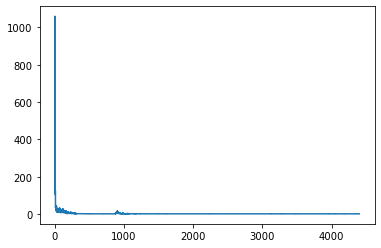

In [16]:
plt.plot(losses2)
plt.show()

In [17]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
NRMSE_improvement = []
NRMSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(val_dataset)):
    gt, image = val_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_8fold(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = torch.tensor(nrmse(gt, output))
    output_loss4 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = torch.tensor(nrmse(gt, image))
    image_loss4 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    NRMSE_improvement.append(output_loss3.item()-image_loss3.item())
    NRMSE_score.append(output_loss3.item())
    MIE_improvement.append(output_loss4 -image_loss4)
    MIE_score.append(output_loss4)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(NRMSE_improvement))
print(np.nanmean(NRMSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


-0.05164701187277828
0.11736405485244265
-0.0003299108624604052
0.0003868689801684608
-0.05697832533499997
0.16730568889916375
-0.0052385544
0.015105624


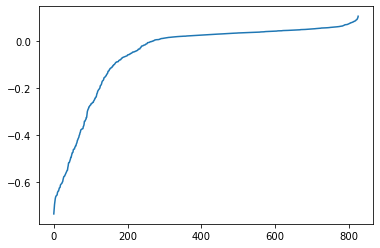

In [18]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

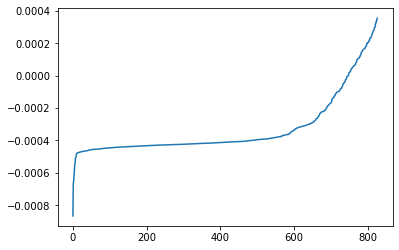

In [19]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

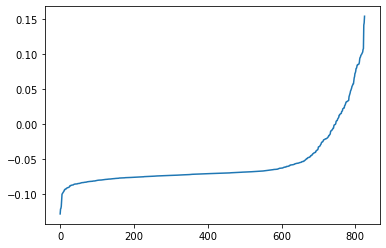

In [20]:
NRMSE_improvement.sort()
plt.plot(NRMSE_improvement)

## save Model

In [21]:
index = 9

In [22]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-model{index}.pt"

In [23]:
#save model to S3 bucket or data
torch.save(network_8fold.state_dict(), output_dir)
#torch.save(network_8fold.state_dict(), './models/resnet18-model.pt')

## Load Model from saved model

In [ ]:
index = 6

In [ ]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(output_dir, map_location=device))
model.eval()

## Predict a single image

In [ ]:
index = 6

In [ ]:
#model_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
model_dir = f"./network_8fold/restnet-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(model_dir, map_location=device))
model.eval()

In [ ]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    MIE_improvement.append(output_loss3 -image_loss3)
    MIE_score.append(output_loss3)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

In [ ]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

In [ ]:
MIE_improvement.sort()
plt.plot(MSE_improvement)

In [ ]:
from PIL import Image

In [ ]:
file_dir = "data/test/images/244.png"

In [ ]:
im_frame = Image.open(file_dir)
   
img_fft, img_fft_noise, img_noise = noise_and_kspace(im_frame)

preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(128),    #128 as maximum
                           T.CenterCrop(128),
                           T.ToTensor() #,
                           #T.Normalize(
                            #        mean=[0.485, 0.456, 0.406],
                               #        std=[0.229, 0.224, 0.225]
                             ##         )
                            ])
img_gt = preprocess(Image.fromarray(np.uint8(im_fft)).convert('L'))
img_und = preprocess(Image.fromarray(np.uint8(img_fft_noise)).convert('L'))
    
n1 = (img_und**2).sum(dim=-1).sqrt()
norm = n1.max() 
if norm < 1e-6: norm = 1e-6
    
img_gt, img_und = img_gt/norm , img_und/norm  
    





In [ ]:
from skimage.metrics import structural_similarity as cmp_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
        gt, pred, multichannel=True, data_range=gt.max()
    )

In [ ]:
    #noise_image = noise_image.to('cuda:0')
#img_gt = img_gt.numpy()
img_und = img_und.unsqueeze(0)
output = model(img_und)
   # output = output.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).detach() #.numpy()   #image under numpy form
#output_loss = torch.tensor(ssim(img_gt, output))  
#image_loss = torch.tensor(ssim(img_gt, img_noise.squeeze(1).numpy()))
#SSIM_improvement = (output_loss.item()-image_loss.item())
#SSIM_score = output_loss.item()

In [ ]:
output.shape

In [ ]:
np_rescontruct_image =  output # np.reshape(output, (64, 64))# image noise numpy array
im_reconstruct = T.ToPILImage()(np_rescontruct_image)#Image.fromarray(np_rescontruct_image).convert('L')
inputa = np.asarray(im_reconstruct)
final = ifftn(ifftshift(inputa))
I = PIL.Image.fromarray(numpy.uint8(final))
I.save("testing/test.png") #for prediction values
I.save("pred1.png")

In [ ]:
display(im_reconstruct)

In [ ]:
display(im_frame)